# Train a Deep Learning Model

During this session, you will learn how to use deep learning on **histopathology images** (hematoxylin and eosin (H&E)-stained tiles from whole slide images (WSIs) of colorectal cancer). The session is composed of 3 different notebooks: <br>
1) **Training** the model (current notebook)
2) **Testing** the model
3) **Applying** the model to classify patches from a whole slide image

We aim to train a deep learning model that assigns **one** of **nine** tissue labels to each image tile (e.g., adipose, background, debris, lymphocytes, mucus, muscle, normal mucosa, stroma, tumor). This is a **single-label multiclass** problem: every tile has exactly one ground-truth class.<br>

**We will implement such a minimal pipeline in the current notebook:**

1. **Data preparation** <br>
We will split our data into train and validation, ensuring no tiles are in the same set to avoid information leakage. Furthermore, we will create transformations of our data, which will apply normalization and light augmentation on the training set only. 
3. **Building the model** <br>
In this step, we will build a small convolutional neural network (CNN) with \(9\) output neurons for each class in our dataset. You will learn what parameters are important and should be tuned for the training to be successful.
4. **Train the model** <br>
Here we will finally train our classifier. The model checkpoint with the lowest validation loss will be saved.
5. **Evaluation (in the next notebook)** <br>
In this step, our model will be tested on unseen data during training (held-out test set). We will look at the overall **accuracy**, **confusion matrix**, and other metrics that reflect per-class performance.  



## About the dataset

We have already downloaded the data for you, which you will find at this path on HPC: [insert path here]. We visualize a few example images from the dataset a few cells below.<br>
The dataset NCT-CRC-HE-100K was downloaded from Zenodo:<br>
> Kather, J. N., Halama, N., & Marx, A. (2018). 100,000 histological images of human colorectal cancer and healthy tissue (v0.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1214456

* It comprises 100000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* All images are **224 x 224** pixels (px) at **0.5** microns per pixel (MPP). All images are **color-normalized** using Macenko's method (http://ieeexplore.ieee.org/abstract/document/5193250/, DOI 10.1109/ISBI.2009.5193250).
* Tissue classes are: Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM).
* These images were manually extracted from **N = 86 H&E** stained human cancer tissue slides from formalin-fixed paraffin-embedded (FFPE) samples from the NCT Biobank (National Center for Tumor Diseases, Heidelberg, Germany) and the UMM pathology archive (University Medical Center Mannheim, Mannheim, Germany). Tissue samples contained CRC primary tumor slides and tumor tissue from CRC liver metastases; normal tissue classes were augmented with non-tumorous regions from gastrectomy specimen to increase variability.

For testing our trained model in the next notebook, we will use **CRC-VAL-HE-7K** dataset. This is a set of **7180** image patches from **N = 50** patients with colorectal adenocarcinoma (no overlap with patients in NCT-CRC-HE-100K). Like in the NCT-CRC-HE-100K data set, images are **224 x 224** px at **0.5** MPP. All tissue samples were provided by the NCT tissue bank, see above for further details and ethics statement.

## Set up a virtual environment for this session

In [ ]:
!bash /data/cat/ws/lazi257c-come2data_workshop/activate_workshop_env.sh

## Imports
First, we will import all the packages needed for this exercise.

In [1]:
import numpy as np
import os, random, math
from tqdm import tqdm
from IPython.display import Image, display

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms, models, datasets
from torchmetrics.classification import MulticlassConfusionMatrix

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from model import SimpleCNN

In the next cell, we set the device that will be used to train the model. It will check if the GPU is available and use it.
Otherwise, the default would be CPU, but it's not recommended for training deep learning models.
In our case, we want to train the model very fast and efficiently, so we will utilize HPC resources, which means you will have access to a very powerful GPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# a few additional settings for making the training faster (good for A100/H100 GPUs (uses Tensor Cores))
if device.type == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True  

Using device: cuda


## Data preparation

In [3]:
# set the correct path to the folder containing the data
data_path = "/data/cat/ws/lazi257c-come2data_workshop/data/NCT-CRC-HE-100K"

In [4]:
# here we scan the folder, and classes can be inferred automatically from folder names. For this, we utilize a class from the torchvision package.
raw_dataset = datasets.ImageFolder(data_path, transform=None)
classes = raw_dataset.classes
num_classes = len(classes)

# let's print the number of found classes, and their names
print(f"Classes (N = {num_classes}):", classes)

Classes (N = 9): ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


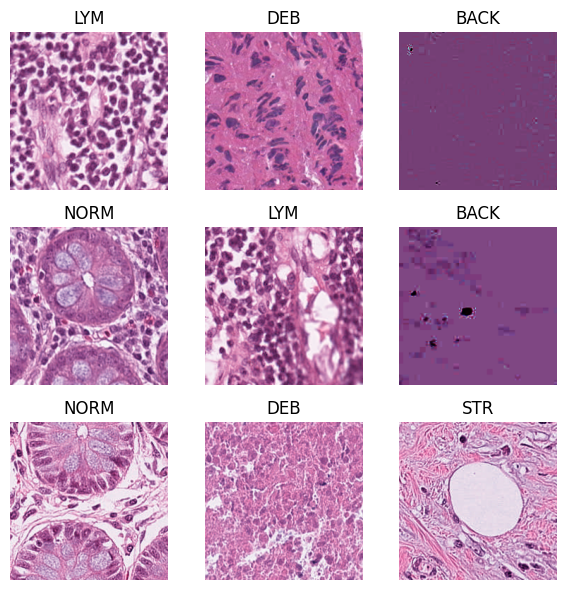

In [5]:
# now let's visualize some random images from our dataset. If you rerun this cell multiple times, you will see different images
fig, axs = plt.subplots(3,3, figsize=(6,6)); axs=axs.ravel()

for ax, i in zip(axs, np.random.choice(len(raw_dataset), 9, replace=False)):
    img, label = raw_dataset[i]   # obtain the image and its label at this random index i
    ax.imshow(np.array(img))
    ax.set_title(raw_dataset.classes[label])   # set the label to be the title of the subplot
    ax.axis("off")

plt.tight_layout()
plt.show()

Label: TUM
PIL size (W,H): (224, 224)
PIL mode: RGB


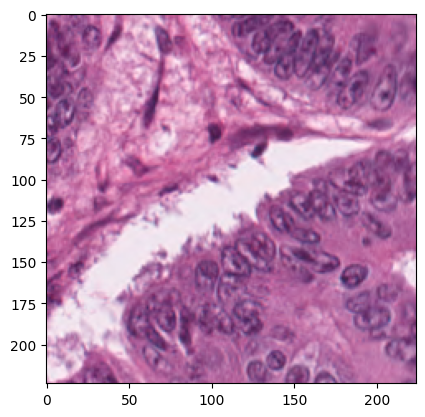

In [6]:
# print the shape and type of a random image

# pick a random index
i = random.randrange(len(raw_dataset))
img, label = raw_dataset[i]

plt.imshow(img)

print("Label:", raw_dataset.classes[label])
print("PIL size (W,H):", img.size)
print("PIL mode:", img.mode)    

To train a deep learning model, we need to split the dataset into training and validation sets. Therefore, in the next cell, we will "assign" a random subsection of the data set as validation images. We will collect indices of images that should be in the validation (val) and train tests, and these indices will be handed to the dataloaders later.

In [9]:
# to train a model, we need to split the dataset into training and validation sets
# here we define the fraction of validation data
val_fraction = 0.2

# the following code will make per-class index lists, shuffle, and split into train/val indices
train_indices, val_indices = [], []
labels = [lbl for _, lbl in raw_dataset.samples]

for c in range(num_classes):
    idxs = [i for i, y in enumerate(labels) if y == c]
    random.shuffle(idxs)
    k = int(round(len(idxs) * val_fraction))
    val_indices.extend(idxs[:k])
    train_indices.extend(idxs[k:])

print(f"Total images: {len(raw_dataset)}  |  Train: {len(train_indices)}  |  Val: {len(val_indices)}")

Total images: 100000  |  Train: 80002  |  Val: 19998


> ### What are data transformations?

Next, we will define transformations that we want to apply to our data. We will perform random horizontal flips and rotation to augment our dataset, and convert the image to a tensor, which is PyTorch’s core n-dimensional array type, similar to a NumPy array, but it can live on CPU or GPU and supports automatic differentiation. Since deep learning is "data hungry", data augmentation helps to get more varied samples.<br><br>

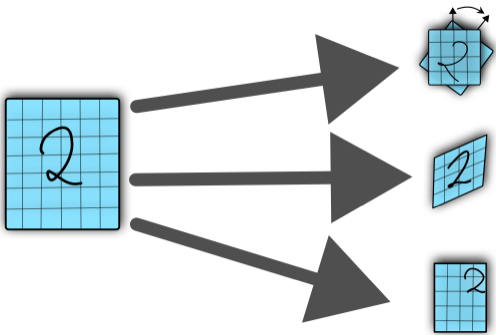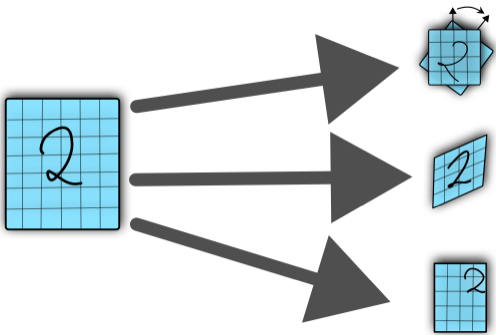

We also need to normalize our data. Initially, our images have pixel values between `0` and `1` (see the plot three cells below). Normalization is the process of transforming these pixel values of each channel to z-scores so that pixel values are centered and comparably scaled, which stabilizes and speeds up training. 

If a **pretrained** model is used (ResNet, ViT, etc.), we should feed inputs that are normalized **the same way the model was trained**. In case of pretraining on **ImageNet** (dataset of natural images) the following values would be correct: `mean = (0.485, 0.456, 0.406)`, `std = (0.229, 0.224, 0.225)`. Using wrong normalization usually **hurts accuracy**. When training from sratch (as we will do), it's best is to **compute dataset-specific** mean/std from the training set and use those. However, for time saving reasons we will skip this step, and use ImageNet values.

In [10]:
train_transform = transforms.Compose([
    #transforms.Resize((x, y)), # optional, we can resize images to a fixed size, but since our tiles are already small (224 x 224 px) we don't need it
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# for validation set, we do not apply data augmentation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])


In [11]:
batch_size = 1024

train_full = datasets.ImageFolder(data_path, transform=train_transform)
val_full   = datasets.ImageFolder(data_path, transform=val_transform)

# select only the indices for each split
train_ds = Subset(train_full, train_indices)
val_ds = Subset(val_full, val_indices)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True, persistent_workers=True, prefetch_factor=6)
val_dataloader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, persistent_workers=True, prefetch_factor=6)

/data/cat/ws/lazi257c-come2data_workshop/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


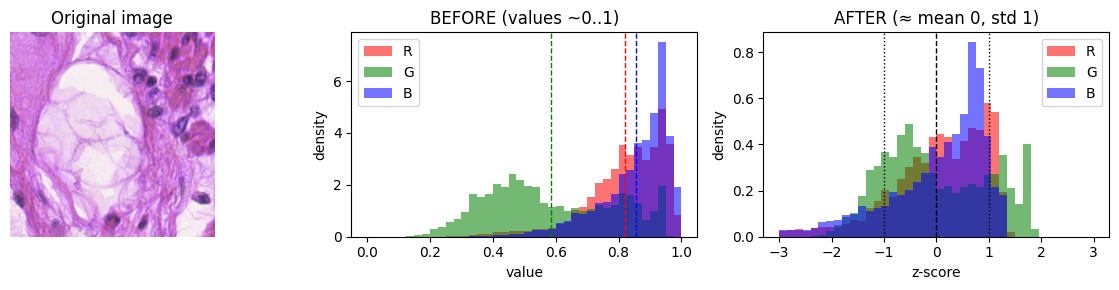

In [13]:
from utils import plot_normalization_example
plot_normalization_example(raw_dataset, img_size=224, idx=55000)

> ### What is a *z-score*?

A **z-score** tells you how many **standard deviations** a value is from the **mean** of its distribution.

## Define the model

In [14]:
# define how many classes we have, because we will need this for the model definition (the number of output neurons)
num_classes = 9

In [15]:
# now we create an instance of our model and move it to the device that was selected in the beginning (in our case GPU)
model = SimpleCNN(num_classes).to(device)

In [27]:
# define the learning rate
learning_rate = 4e-3

# define number of epochs - how many iterations the model will do over our training data
# keep in mind limited time for the exercise and that 1 epoch will take ~30s
number_of_epochs = 20
steps_per_epoch = math.ceil(len(train_dataloader))

**CrossEntropyLoss** is a commonly used loss function for classification tasks. The goal of this loss function is to measure the difference between the predicted probabilities of the model and the true probabilities of the target variable.

In [28]:
# define our loss function and the optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-4, fused=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=number_of_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,              # 10% warmup
    anneal_strategy="cos",      # cosine decay
    div_factor=10,              # start at max_lr/10
    final_div_factor=100        # end small
)

In [29]:
# here we define what happens in one epoch
def one_epoch(loader, train=True):
    model.train(train)                           # set training mode if train=True; else eval mode (affects dropout/batchnorm)
    total_loss, total_correct, total = 0.0, 0, 0 # running totals for loss, correct predictions, and number of samples
    for x, y in tqdm(loader, leave=False):       # iterate over batches from the loader with a progress bar
        x, y = x.to(device), y.to(device)        # send batch (x-img tensor, y-labels) to GPU/CPU as defined by `device`
        logits = model(x)                        # forward pass: raw class scores (logits), shape (B, num_classes)
        loss = criterion(logits, y)                # compute loss comparing logits to ground-truth labels

        if train:                                # only update weights during training
            optimizer.zero_grad(set_to_none=True)# clear old gradients (faster/more memory-friendly with None)
            loss.backward()                      # backpropagate: compute gradients with respect to model parameters
            optimizer.step()                     # take an optimization step to update parameters

        total_loss += loss.item() * x.size(0)    # accumulate loss * batch_size (for epoch-average later)
        total_correct += (logits.argmax(1) == y).sum().item()  # count correct predictions in this batch
        total += x.size(0)                       # accumulate number of samples seen

    return total_loss/total, total_correct/total # return average loss and accuracy over the epoch


## Train the model

In [30]:
# we define best validation loss to be infinity at the beginning, so that the first epoch will always be better and save the model, 
# and then save after it gets lower
best_val_loss = float("inf")

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(number_of_epochs):
    train_loss, train_acc = one_epoch(train_dataloader, train=True)
    val_loss,   val_acc   = one_epoch(val_dataloader, train=False)

    # keep training history so that we can plot it later
    train_losses.append(train_loss);  val_losses.append(val_loss)
    train_accs.append(train_acc);     val_accs.append(val_acc)

    print(f"epoch {epoch:02d} | train {train_loss:.3f}/{train_acc:.3f} | "
          f"val {val_loss:.3f}/{val_acc:.3f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({"state_dict": model.state_dict(),
                    "classes": classes, "img_size": 224},
                    "best_model.pth")
        print("  ↳ saved best model to best_model.pth")


epoch 00 | train 1.664/0.467 | val 1.365/0.577
  ↳ saved best model to best_model.pth


epoch 01 | train 1.215/0.649 | val 1.121/0.700
  ↳ saved best model to best_model.pth


epoch 02 | train 1.046/0.725 | val 0.994/0.745
  ↳ saved best model to best_model.pth


epoch 03 | train 0.945/0.767 | val 0.947/0.747
  ↳ saved best model to best_model.pth


epoch 04 | train 0.880/0.786 | val 0.861/0.788
  ↳ saved best model to best_model.pth


epoch 05 | train 0.833/0.801 | val 0.808/0.810
  ↳ saved best model to best_model.pth


epoch 06 | train 0.795/0.814 | val 0.775/0.824
  ↳ saved best model to best_model.pth


epoch 07 | train 0.759/0.829 | val 0.758/0.832
  ↳ saved best model to best_model.pth


epoch 08 | train 0.725/0.847 | val 0.703/0.858
  ↳ saved best model to best_model.pth


epoch 09 | train 0.695/0.860 | val 0.678/0.871
  ↳ saved best model to best_model.pth


epoch 10 | train 0.670/0.871 | val 0.651/0.881
  ↳ saved best model to best_model.pth


epoch 11 | train 0.647/0.882 | val 0.636/0.887
  ↳ saved best model to best_model.pth


epoch 12 | train 0.629/0.888 | val 0.618/0.894
  ↳ saved best model to best_model.pth


epoch 13 | train 0.612/0.896 | val 0.602/0.901
  ↳ saved best model to best_model.pth


epoch 14 | train 0.601/0.900 | val 0.601/0.899
  ↳ saved best model to best_model.pth


epoch 15 | train 0.589/0.905 | val 0.575/0.905
  ↳ saved best model to best_model.pth


epoch 16 | train 0.575/0.910 | val 0.571/0.911
  ↳ saved best model to best_model.pth


epoch 17 | train 0.565/0.914 | val 0.561/0.915
  ↳ saved best model to best_model.pth


epoch 18 | train 0.556/0.917 | val 0.550/0.913
  ↳ saved best model to best_model.pth


epoch 19 | train 0.548/0.920 | val 0.542/0.920
  ↳ saved best model to best_model.pth


## Plot training curves

When a neural network is being trained, its loss function is used to measure the difference between the predicted output and the true output for a given set of input data. During training, the goal is to minimize the loss function by adjusting the weights and biases of the network.

We can interpret the performance of the network during training by looking at the trend of the loss over time. Ideally, we want to see the loss decrease over time as the network becomes better at making accurate predictions. If the loss is decreasing too slowly or not at all, it may indicate that the learning rate is too low or that the model is too complex and prone to overfitting. On the other hand, if the loss is decreasing rapidly and then starts to increase again, it may indicate that the learning rate is too high or that the model is not sufficiently regularized.

Also, to see how good our network is at actually predicting the right class, we calculate the accuracy, which is the sum of all correctly predicted images divided by the total number of images. While training, this is done on the validation set and can be plotted after the training is done or for live monitoring.


> *Hint:*
A slow loss decline might be a sign to increase the learning rate, while oscillating functions with high amplitudes can be a sign of a too high learning rate. <br>

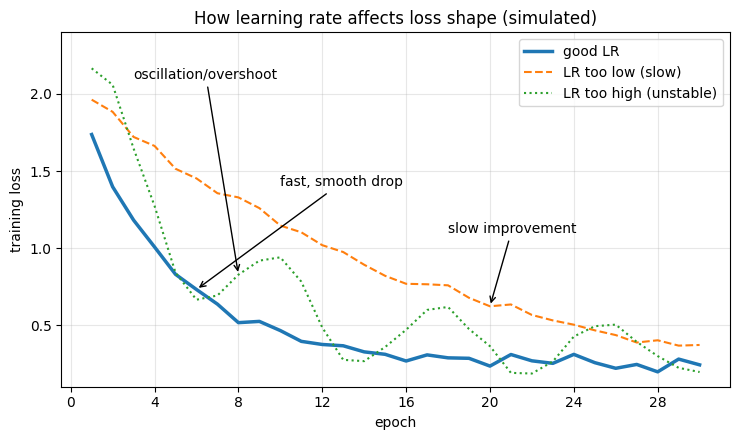

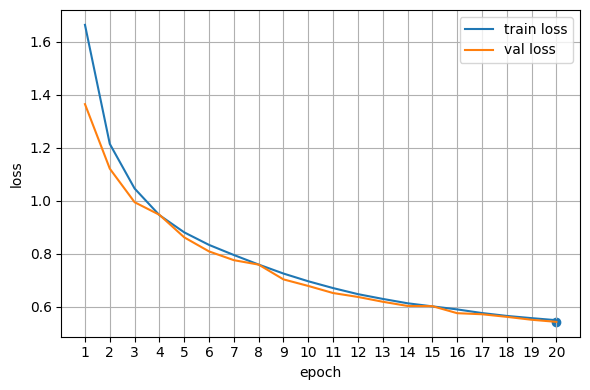

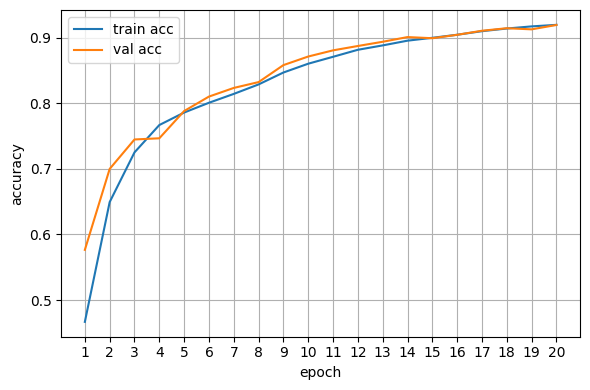

In [32]:
epochs = np.arange(1, len(train_losses)+1)

# Loss curve
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_losses, label="train loss")
ax.plot(epochs, val_losses,   label="val loss")
best_e = int(np.argmin(val_losses)) + 1
ax.scatter([best_e], [val_losses[best_e-1]])  # mark best val loss
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.set_xticks(epochs)
plt.tight_layout()
plt.show()

# Accuracy curve
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(epochs, train_accs, label="train acc")
ax.plot(epochs, val_accs,   label="val acc")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.set_xticks(epochs)
plt.tight_layout()
plt.show()

## What happened while training our model?
We can see our network as a mathematical function that takes an image as an input and returns a vector as an output, where each vector-cell represents the possibility of the image being part of the related class. <br>

The variables to customize the network to our dataset are called weights and biases. During the training, we use a batch of images, feed it to our network, and calculate the loss. <br>

The loss is the difference between the predicted output and the one we would ideally receive.

With the loss and a gradient descent algorithm, we can now slightly change our weights in every step.

Repeating this procedure many times gives us the trained network.

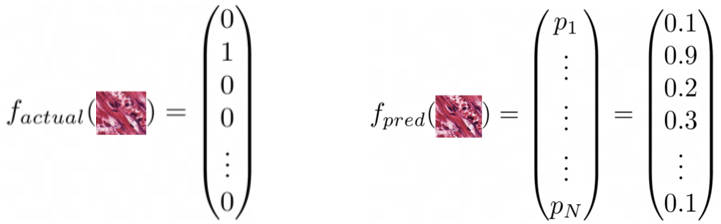
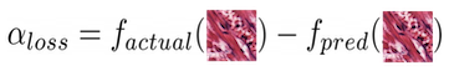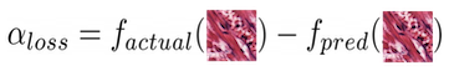